In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize


# Problem:
# minimize: lambda_param * sqrt( sum(sigma^2 * x_t^2) ) + sum( 0.5 * abs(q_t) * p(q_t) )
# such that: sum(q_t) = S

### where:
### we sum over t=1 to t=n, where
### n            = number of time increments we have to execute all of a trade
### lambda_param = risk aversion to not executing immidiately
### sigma        = volatility of the asset you want to buy
### x_t          = quantity we hold of the asset at time t
### q_t          = quantity we trade at each time t
### p(q_t)       = bid-ask spread paid for an order of q_t
### S            = total quantity we want to sell

### We set S = 100, n = 5, sigma = 0.1


# objective function
def to_be_minimized(q, lambda_param):
    # q == # of shares to buy each day
    # We substituted in the constraint (ie "such that: sum(q_t) = S") to have an n-1 dimensional problem: 
    ### for ex, once you know how much to trade on the first n-1 days, the # of trades on day n is also known
    q = list(q)
    q.append(S-sum(q))
    
    # x == # of remaining shares you still have to execute on each day
    ### for ex, if S=100 and q=[15, 25, 18, 22, 20], we have x = [100, 85, 60, 42, 20]
    x = [S] + list(S - np.cumsum(q[:n-1]))
    
    # bid-ask spread paid for trading q_t shares at once
    def p(q_t):
        return(0.1 + 0.05*np.exp(0.03*q_t))

    return( lambda_param*np.sqrt(sum([sigma2 * (i**2) for i in x]))  +  0.5*sum([abs(i)*p(i) for i in q]) )

# parameters
S = 100
n = 5
sigma2 = 0.1**2

# initial guess
q0  = [15, 25, 18, 22] # starting point is 15 1st day, 25 2nd day, ..., 22 4th day, and (100 - sum(q0)) 5th day

# try with a specific lambda_param
lambda_param = 1
q_opt = optimize.minimize(to_be_minimized, q0, args=(lambda_param)).x # lamba_param is an extra argument, use args
q_opt = list(q_opt) + [S-sum(q_opt)]
q_opt


[35.10323164077475,
 25.819057246659145,
 17.863138703900013,
 12.101044543838928,
 9.113527864827176]

In [2]:
# try with different lambdas
lambda_params = [0, 0.1, 1, 10, 100, 1000]


q = pd.DataFrame(index=range(1,n+1), columns = lambda_params)
for lambda_param in lambda_params:
    q_opt = optimize.minimize(to_be_minimized, q0, args=(lambda_param)).x
    q_opt = list(q_opt) + [S-sum(q_opt)]
    q[lambda_param] = q_opt

q

,0.0,0.1,1.0,10.0,100.0,1000.0
1,20.001363,22.171327,35.103232,62.638001,87.758442,9.815310e+01
2,20.001079,20.749372,25.819057,29.108532,12.022737,1.843246e+00
3,19.999007,19.649036,17.863139,5.737442,0.204539,1.142253e-03
4,19.998554,18.905527,12.101045,2.512237,0.000002,4.881522e-10
5,19.999997,18.524738,9.113528,0.003787,0.014279,2.508165e-03


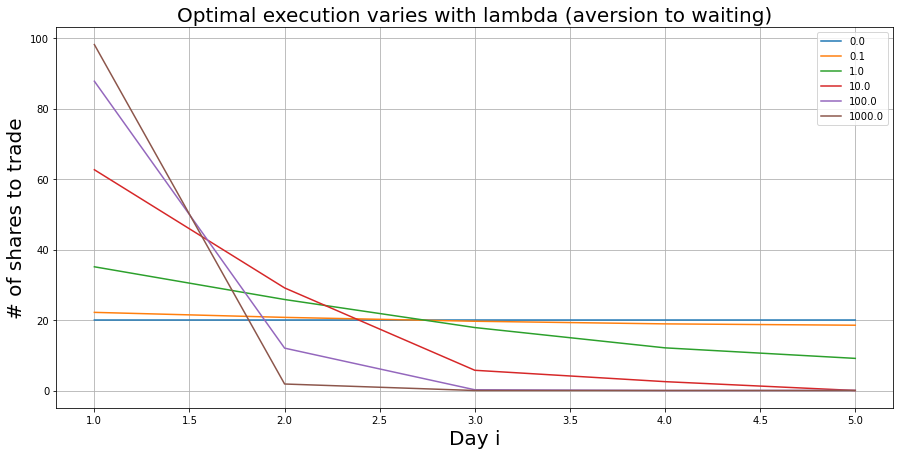

In [3]:
q.plot(figsize = (15,7))
plt.legend()
plt.grid()
plt.title('Optimal execution varies with lambda (aversion to waiting)', size=20)
plt.ylabel('# of shares to trade', size=20)
plt.xlabel('Day i', size=20)

plt.show()